# Imports & Consts

In [3]:
from matplotlib import pyplot as plt
import wandb
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [4]:
from dataset import create_dataset
from model import build_model
from train import train_model
from predict import predict_model
from evaluate import evaluate_model

In [ ]:
OUTPUT_MASK_FILE = "../airbus-ship-detection/reduced_train_ship_segmentations_v2.csv"

DATA_FOLDER = "../airbus-ship-detection/train_v2"
MODEL_PATH = "reduced_model.h5"
TEST_SIZE = 1000
VALIDATION_SIZE = 1000
MASK_SIZE = (256, 256, 1)
BATCH_SIZE = 32

np.random.seed(42)
wandb.init()

# Creating Datasets

In [6]:
image_ids = pd.read_csv(OUTPUT_MASK_FILE)['ImageId'].to_list() #images are already shuffled
test_ids = image_ids[:TEST_SIZE]
val_ids = image_ids[TEST_SIZE:VALIDATION_SIZE+TEST_SIZE]
train_ids = image_ids[VALIDATION_SIZE+TEST_SIZE:]

In [7]:
train_ds, val_ds, test_ds = create_dataset(train_ids, val_ids, test_ids, OUTPUT_MASK_FILE, DATA_FOLDER)

# Training Model

In [ ]:
model = build_model()
train_model(model, train_ds, val_ds)

# Predicting Masks

In [8]:
prediction = predict_model(MODEL_PATH, test_ds)

32/32 [==============================] - 62s 2s/step


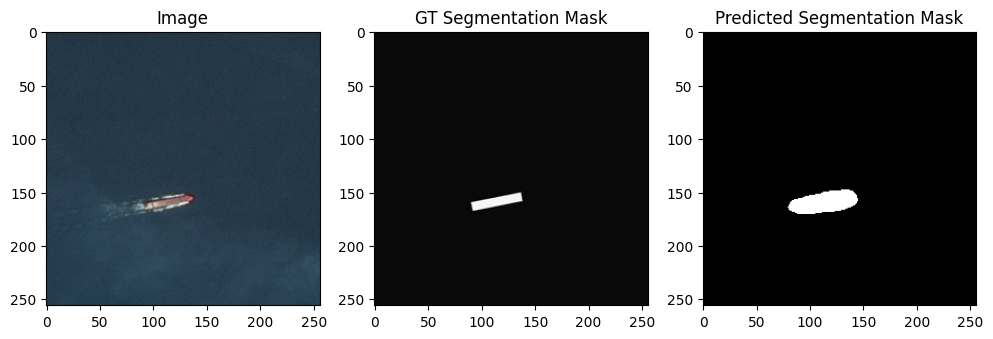

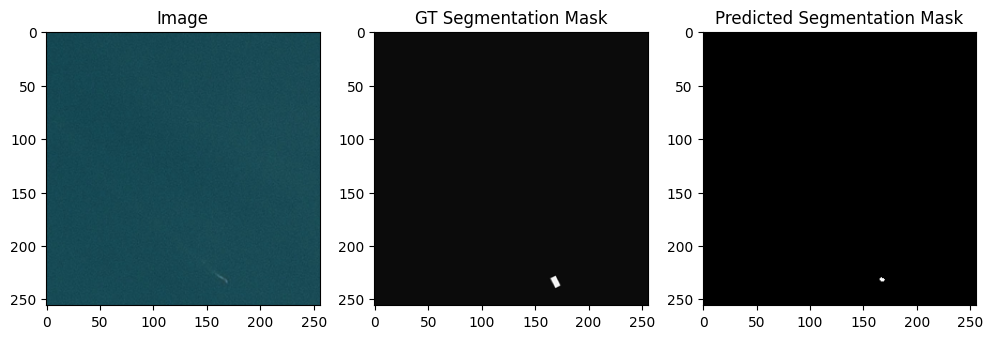

In [12]:
indeces = [4, 6]
for index in indeces:
    fig, axes = plt.subplots(1, 3)
    fig.set_figheight(16)
    fig.set_figwidth(12)

    axes[0].imshow(test_ds[0][0][index], cmap='gray')
    axes[0].set_title("Image")

    axes[1].imshow(test_ds[0][1][index], cmap='gray')
    axes[1].set_title("GT Segmentation Mask")

    axes[2].imshow(prediction[index], cmap='gray')
    axes[2].set_title("Predicted Segmentation Mask")

plt.show()

# Evaluating Model

In [13]:
acc_val, dice_val = [], []
for batch_num in range(len(test_ds)):
    acc, dice = evaluate_model(test_ds[batch_num][1].flatten(), prediction[batch_num*BATCH_SIZE:(batch_num+1)*BATCH_SIZE].flatten().astype("float32"))
    acc_val.append(acc)
    dice_val.append(dice)
print(f"Accuracy: {np.mean(acc_val)*100:.02f}%")
print(f"Dice score: {np.mean(dice_val)*100:.02f}%")

Accuracy: 97.14%
Dice score: 28.07%


Though it might seem that dice score is pretty low, it is important to notice how imbalanced the mask class is with inconsistencies of real shapes of objects as well as limitation of computational resources:) One should train the model for longer with full resolution (768 by 768) including data augmentation techniques as well as artificial construction of images which consist of patches of real images but where the ship area is much higher.

In [14]:
def metrics_distribution(metric_values: list, metric_name: str):
    """
    Plots distribution of obtained test metrics aggregated to the level of batches.
    """
    histogram = go.Histogram(
        x=metric_values
    )
    layout = go.Layout(
        title=f'{metric_name} distribution accross batches',
        xaxis=dict(title=f'{metric_name} value'),
        yaxis=dict(title='Frequency')
    )
    fig = go.Figure(data=[histogram], layout=layout)
    fig.show()

In [15]:
metrics_distribution(acc_val, "Accuracy")

In [16]:
metrics_distribution(dice_val, "Dice score")